In [72]:
### Introduction:

In this project, I aim to develop a classifier that can predict customer churn for SyriaTel, a telecommunications company. Customer churn refers to customers who are likely to discontinue their services in the near future, posing a significant financial impact on the company. By utilizing predictive modeling techniques, I aim to identify patterns and trends within customer behavior and usage data to forecast whether a customer is at risk of churning. Through binary classification, my goal is to provide SyriaTel with actionable insights to proactively address customer retention strategies and minimize revenue loss associated with churn. Through this analysis, I aim to discover predictable patterns that can empower the telecom business to optimize customer retention efforts and enhance overall profitability.

### Business Understanding:

![Churn Output](Images/churn_out.jpg)


SyriaTel, a telecommunications company, is struggling with a substantial challenge: customer churn, which directly impacts their financial performance. To address this issue, they've initiated a predictive analytics project aimed at identifying customers at risk of churn in the near future. Leveraging historical customer data encompassing demographic information, usage patterns, and service interactions, I'm constructing a binary classifier model. This model, iteratively refined using various machine learning algorithms, provides real-time predictions of churn likelihood, enabling SyriaTel to proactively engage with at-risk customers through personalized retention strategies. Ultimately, this predictive approach empowers SyriaTel to optimize marketing efforts, enhance customer retention initiatives, and drive overall profitability.

In [73]:
### Data Understanding:

![Exploration](exploration.jpg)


## Data Understanding

In preparing to use predictive modeling (logistic regression, random forests) for churn prediction at SyriaTel, the initial step involves collecting historical customer data encompassing demographics, usage patterns, subscription details, and service interactions.

Subsequently, a thorough exploration of the dataset is conducted to understand its structure, identify relevant features, and preprocess the data to handle missing values and categorical variables.

Following data splitting into training and testing sets, logistic regression and random forests are trained on the training data and evaluated using metrics like accuracy and F1 score.

Through model optimization, hyperparameters are fine-tuned to enhance predictive performance, ensuring the model's robustness and interpretability.

Ultimately, this approach enables SyriaTel to gain insights into customer churn drivers and implement targeted retention strategies effectively.


###Data Preparation:

Importing all the necessary libraries below:

In [74]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced data visualization
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold  # For splitting data into train and test sets
from sklearn.preprocessing import StandardScaler  # For standardizing numerical features
from sklearn.linear_model import LogisticRegression  # For logistic regression model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_curve, auc,roc_auc_score,make_scorer,f1_score # For model evaluation metrics
from sklearn.dummy import DummyClassifier # For creating dummy models and comparing it to our own
from sklearn.model_selection import GridSearchCV  # For hyperparameter tuning
import warnings
warnings.filterwarnings("ignore") # For filtering out annoying warnings lol
from sklearn.preprocessing import LabelEncoder # For the boolean values in the dataset
import itertools 

DataProcessing Class Definition (Initialization):

Load the CSV file and examine the columns to gain an understanding of the dataset's structure and the specific features available for analysis.

In [75]:


class DataProcessing:
    def __init__(self, file_path):
        self.df = pd.read_csv(file_path)
        
    def load_data(self):
        self.df.info()
        print(self.df.head())
    
    def select_columns(self):
        object_columns = ['state', 'voice mail plan', 'international plan', 'phone number']
        selected_columns = self.df.loc[:, object_columns]
        print(selected_columns.head())
    
    def convert_voice_mail_plan(self):
        self.df['voice mail plan'] = self.df['voice mail plan'].apply(lambda x: True if x == 'yes' else False)
        print("Voice Mail Plan Value Counts:")
        print(self.df['voice mail plan'].value_counts())
    
    def convert_international_plan(self):
        self.df['international plan'] = self.df['international plan'].apply(lambda x: True if x == 'yes' else False)
        print("International Plan Value Counts:")
        print(self.df['international plan'].value_counts())
    
    def encode_state(self):
        encoded_states = pd.get_dummies(self.df['state'], prefix='encoded', drop_first=True)
        self.df = pd.concat([self.df.drop(columns='state'), encoded_states], axis=1)
        self.df.info()
    
    def encode_area_code(self):
        encoded_area = pd.get_dummies(self.df['area code'], prefix='encoded', drop_first=True)
        self.df = pd.concat([self.df.drop(columns='area code'), encoded_area], axis=1)
        self.df.info()
    
    def drop_phone_number(self):
        self.df = self.df.drop(columns='phone number')
    
    def check_duplicates(self):
        duplicates = self.df.duplicated().sum()
        print(f"Number of duplicate rows: {duplicates}")
    
    def display_churn_counts(self):
        print("Churn Value Counts:")
        print(self.df['churn'].value_counts())
    
    def scale_features(self):
        features_to_scale = ['account length', 'number vmail messages', 'total day minutes', 'total day calls',
                             'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge',
                             'total night minutes', 'total night calls', 'total night charge', 'total intl minutes',
                             'total intl calls', 'total intl charge', 'customer service calls']
        scaler = StandardScaler()
        self.df[features_to_scale] = scaler.fit_transform(self.df[features_to_scale])
        print(self.df.describe())







In [76]:
file_path = 'Datasets/Customer Churn.csv'
processing = DataProcessing(file_path)

# Load and display data
processing.load_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

The dataset contains information about 3,333 customers, including various attributes related to their account and usage of telecommunication services. Here's a breakdown of the data columns and some insights:

state: The state in which the customer resides (categorical variable).

account length: Duration of the customer's account in days (integer).

area code: Area code associated with the customer's phone number (integer).

phone number: The customer's phone number (categorical variable). 

international plan: Whether the customer has an international calling plan (categorical variable: 'yes' or 'no').

voice mail plan: Whether the customer has a voice mail plan (categorical variable: 'yes' or 'no').

number vmail messages: The number of voice mail messages (integer).

total day minutes: Total minutes of calls during the day (float).

total day calls: Total number of calls during the day (integer).

total day charge: Total charge for calls during the day (float).

total eve minutes: Total minutes of calls during the evening (float).

total eve calls: Total number of calls during the evening (integer).

total eve charge: Total charge for calls during the evening (float).

total night minutes: Total minutes of calls during the night (float).

total night calls: Total number of calls during the night (integer).

total night charge: Total charge for calls during the night (float).

total intl minutes: Total minutes of international calls (float).

total intl calls: Total number of international calls (integer).

total intl charge: Total charge for international calls (float).

customer service calls: Number of calls to customer service (integer).

churn: Whether the customer has churned (boolean).

In [77]:
# Select specific columns
processing.select_columns()

  state voice mail plan international plan phone number
0    KS             yes                 no     382-4657
1    OH             yes                 no     371-7191
2    NJ              no                 no     358-1921
3    OH              no                yes     375-9999
4    OK              no                yes     330-6626


I defined a method to select specific columns from the DataFrame that are relevant for further processing. Here, I selected columns that are categorical.

The dataset is complete, with no missing values, but it includes a mix of string (categorical) and float (numerical) data types. To prepare for the regression model, it is necessary to convert the categorical variables to numerical representations.

In [78]:
# Convert 'voice mail plan' to boolean values
processing.convert_voice_mail_plan()

# Convert 'international plan' to boolean values
processing.convert_international_plan()

Voice Mail Plan Value Counts:
voice mail plan
False    2411
True      922
Name: count, dtype: int64
International Plan Value Counts:
international plan
False    3010
True      323
Name: count, dtype: int64


The 'voice mail plan' and 'international plan' columns have been converted to boolean values as shown above.

Given their significance, one-hot encoding can be applied to categorize the states as well as area code, so as to enable Logistic Regression analysis. 

In [79]:
# Perform one-hot encoding for the 'area code' column
processing.encode_area_code()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   phone number            3333 non-null   object 
 3   international plan      3333 non-null   bool   
 4   voice mail plan         3333 non-null   bool   
 5   number vmail messages   3333 non-null   int64  
 6   total day minutes       3333 non-null   float64
 7   total day calls         3333 non-null   int64  
 8   total day charge        3333 non-null   float64
 9   total eve minutes       3333 non-null   float64
 10  total eve calls         3333 non-null   int64  
 11  total eve charge        3333 non-null   float64
 12  total night minutes     3333 non-null   float64
 13  total night calls       3333 non-null   int64  
 14  total night charge      3333 non-null   

In [85]:
processing.encode_state()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 70 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          3333 non-null   float64
 1   international plan      3333 non-null   bool   
 2   voice mail plan         3333 non-null   bool   
 3   number vmail messages   3333 non-null   float64
 4   total day minutes       3333 non-null   float64
 5   total day calls         3333 non-null   float64
 6   total day charge        3333 non-null   float64
 7   total eve minutes       3333 non-null   float64
 8   total eve calls         3333 non-null   float64
 9   total eve charge        3333 non-null   float64
 10  total night minutes     3333 non-null   float64
 11  total night calls       3333 non-null   float64
 12  total night charge      3333 non-null   float64
 13  total intl minutes      3333 non-null   float64
 14  total intl calls        3333 non-null   


I excluded the 'phone number' column from the dataset since it contains unique values, which are not relevant for analysis or modeling purposes.

In [80]:
# Drop 'phone number' column
processing.drop_phone_number()

In [82]:
# Check for duplicates
processing.check_duplicates()

# Display the count of churn values
processing.display_churn_counts()

Number of duplicate rows: 0
Churn Value Counts:
churn
False    2850
True      483
Name: count, dtype: int64


I displayed the value counts for the 'churn' column to understand the distribution of the target variable. This helps in understanding the class distribution and identifying any potential imbalance.

In [83]:


# Scale specific features
processing.scale_features()

       account length  number vmail messages  total day minutes  \
count    3.333000e+03           3.333000e+03       3.333000e+03   
mean    -8.527366e-18          -5.969156e-17      -5.329603e-19   
std      1.000150e+00           1.000150e+00       1.000150e+00   
min     -2.513172e+00          -5.917599e-01      -3.301096e+00   
25%     -6.797448e-01          -5.917599e-01      -6.624241e-01   
50%     -1.627644e-03          -5.917599e-01      -6.887677e-03   
75%      6.513740e-01           8.695542e-01       6.725198e-01   
max      3.564766e+00           3.134591e+00       3.140422e+00   

       total day calls  total day charge  total eve minutes  total eve calls  \
count     3.333000e+03      3.333000e+03       3.333000e+03     3.333000e+03   
mean      3.197762e-18      2.131841e-18      -1.705473e-17     1.545585e-17   
std       1.000150e+00      1.000150e+00       1.000150e+00     1.000150e+00   
min      -5.005247e+00     -3.301162e+00      -3.963622e+00    -5.025911e+00

Finally, I performed feature scaling only on the continuous features, excluding the one-hot encoded variables and boolean data types. Scaling is important as it brings all the features to the same scale, which improves the performance of machine learning models. I used StandardScaler from sklearn for this purpose, which standardizes the features by removing the mean and scaling to unit variance.


In [88]:
class EDA(DataProcessing):
    def univariate_analysis(self):
        continuous_vars = ['account length', 'number vmail messages', 'total day minutes', 'total day calls', 
                           'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge']
        
        categorical_vars = ['international plan', 'voice mail plan']
        
        for var in continuous_vars:
            plt.figure(figsize=(10, 6))
            sns.histplot(self.df[var], kde=True)
            plt.title(f'Distribution of {var}')
            plt.xlabel(var)
            plt.ylabel('Frequency')
            plt.show()
        
        for var in categorical_vars:
            plt.figure(figsize=(10, 6))
            sns.countplot(x=var, data=self.df)
            plt.title(f'Count of {var}')
            plt.xlabel(var)
            plt.ylabel('Count')
            plt.show()
    
    def bivariate_analysis(self):
        plt.figure(figsize=(14, 8))
        sns.boxplot(x='churn', y='total day minutes', data=self.df)
        plt.title('Total Day Minutes by Churn')
        plt.show()
        
        churn_matrix = pd.crosstab(self.df['international plan'], self.df['voice mail plan'], normalize='index')
        plt.figure(figsize=(10, 6))
        sns.heatmap(churn_matrix, annot=True, cmap='Blues')
        plt.title('Heatmap of International Plan vs Voice Mail Plan')
        plt.show()
        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='total day minutes', y='total day charge', hue='churn', data=self.df)
        plt.title('Total Day Minutes vs Total Day Charge')
        plt.show()
        
        # Only include numerical columns for the correlation heatmap
        numerical_df = self.df[['account length', 'number vmail messages', 'total day minutes', 'total day calls', 
                                'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge']]
        
        plt.figure(figsize=(14, 8))
        sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Heatmap')
        plt.show()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

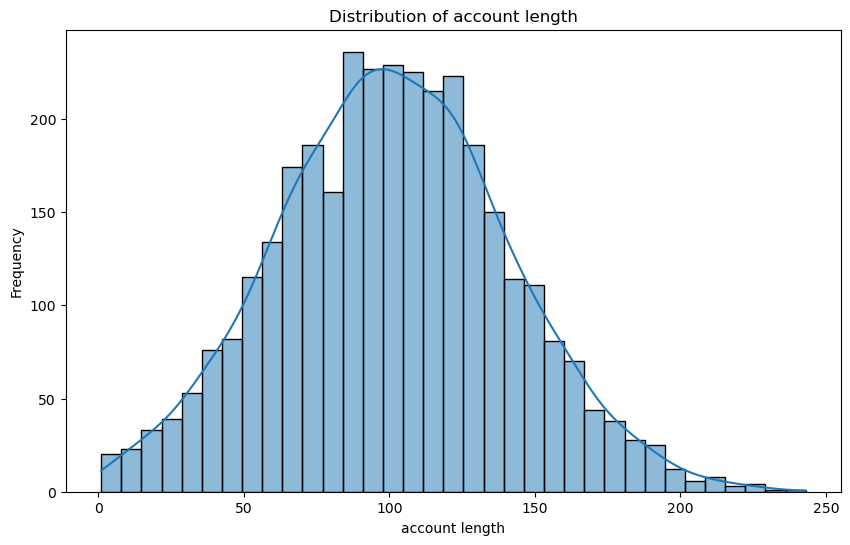

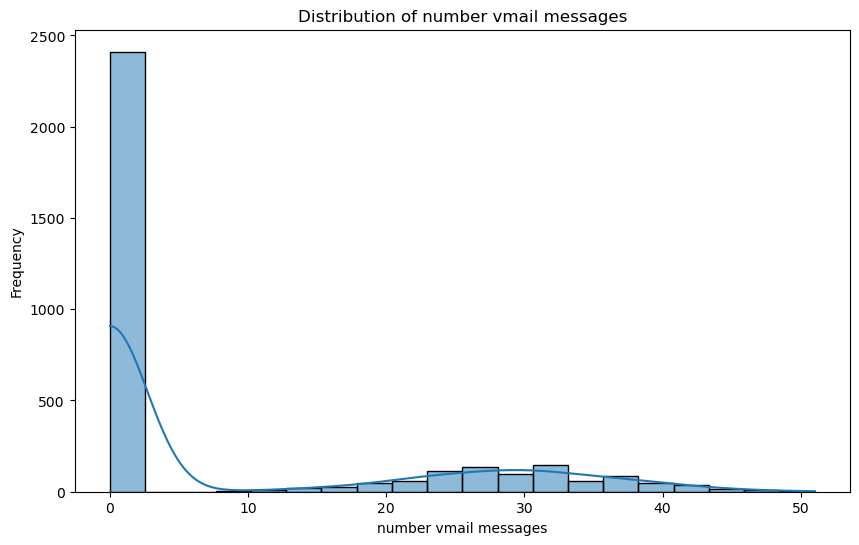

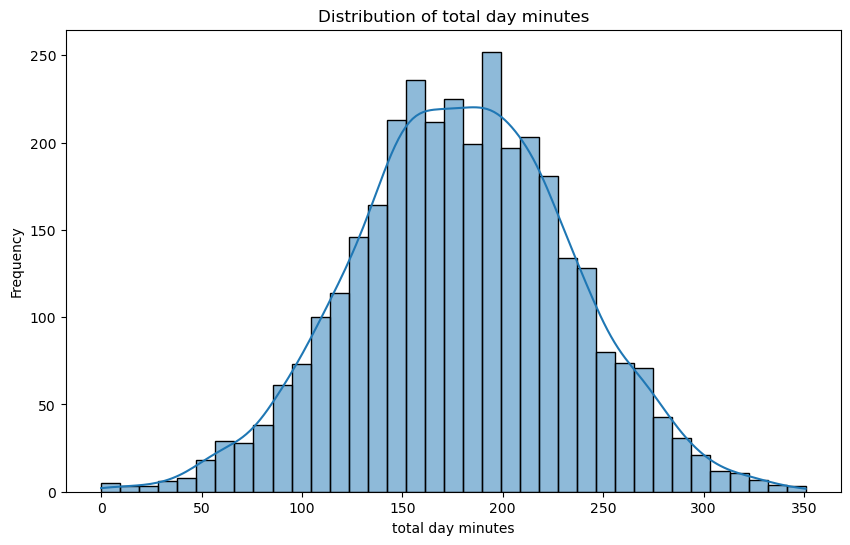

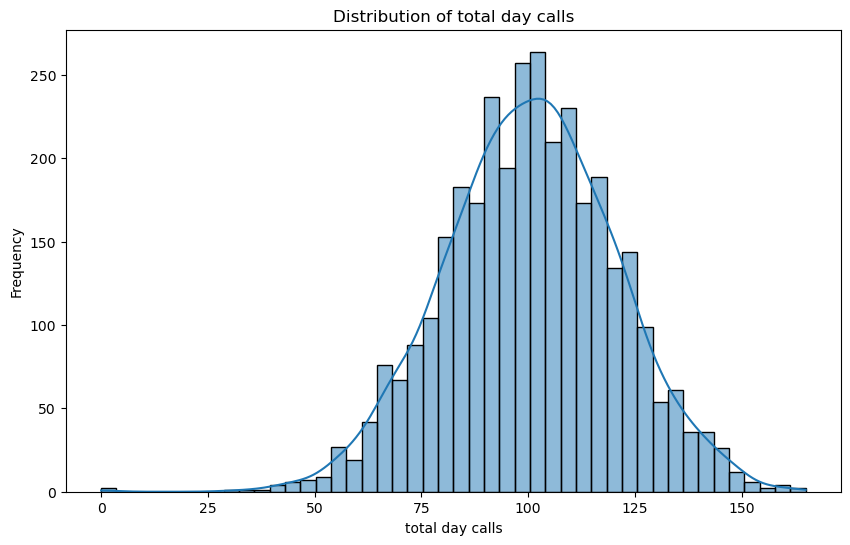

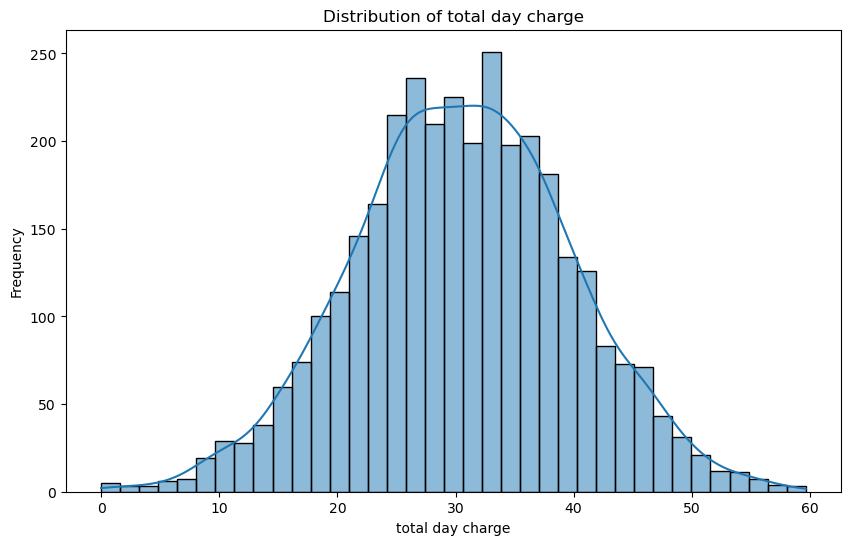

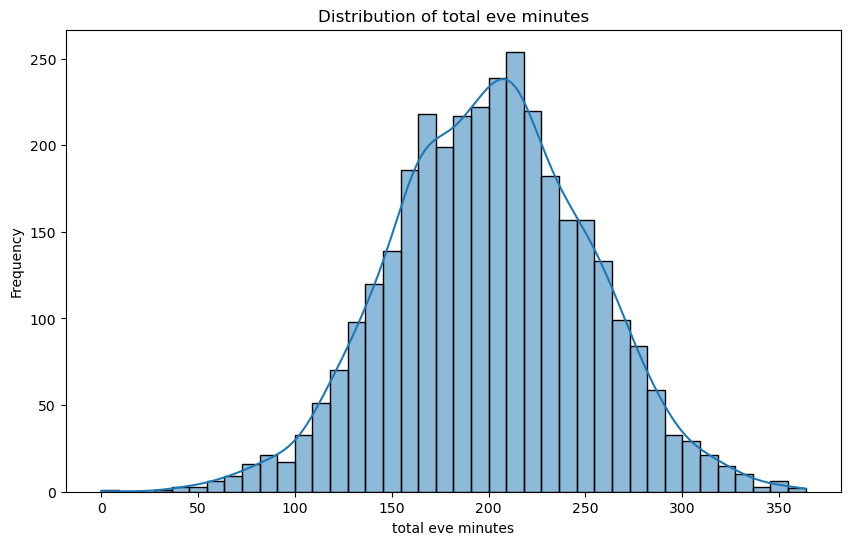

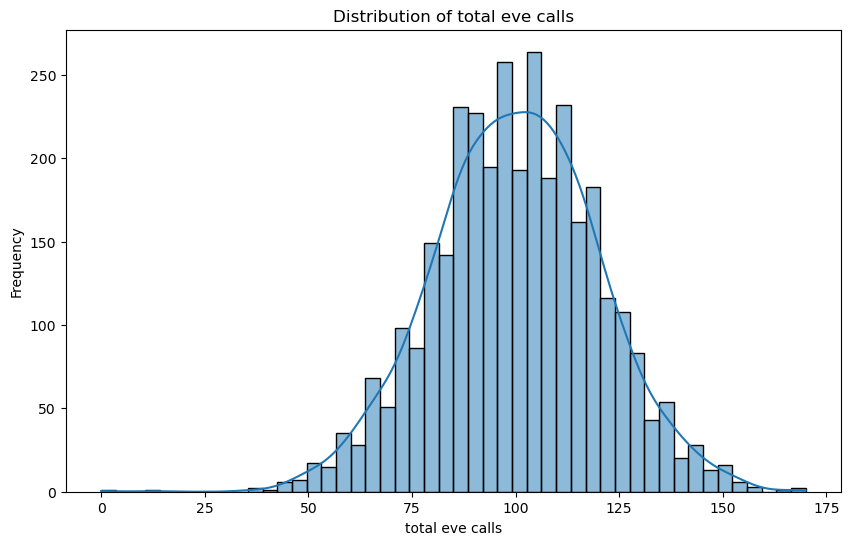

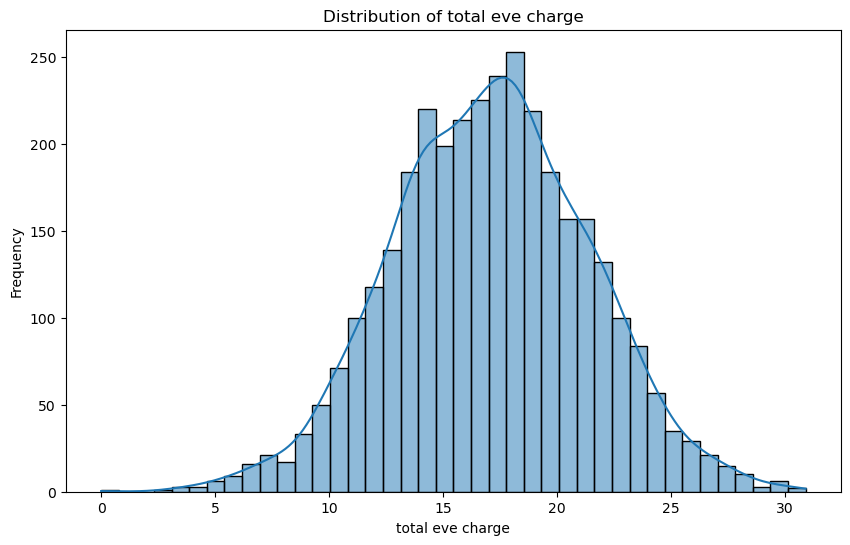

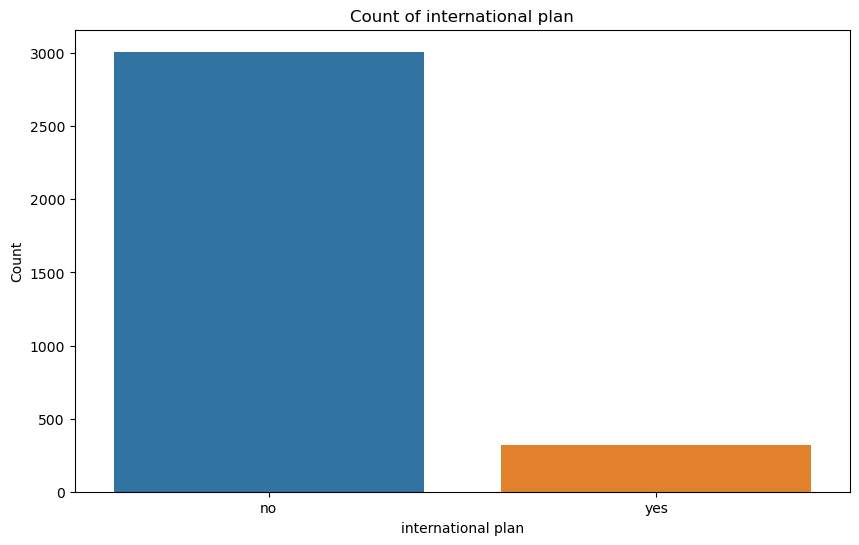

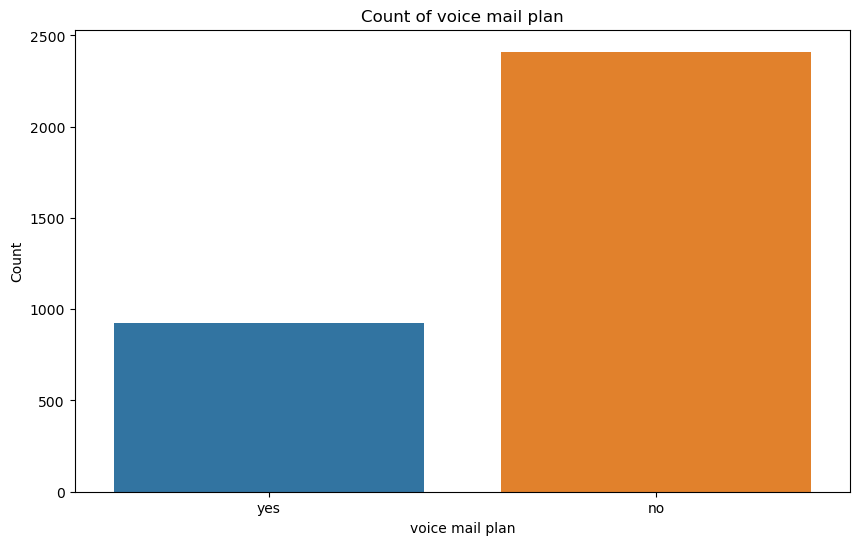

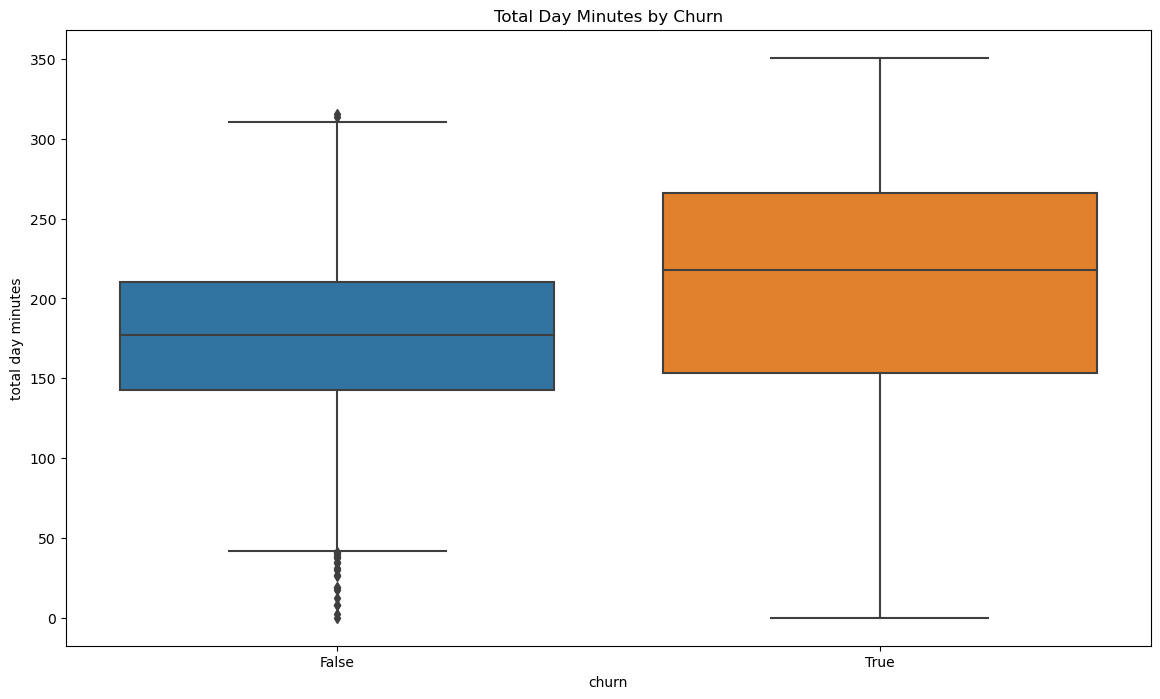

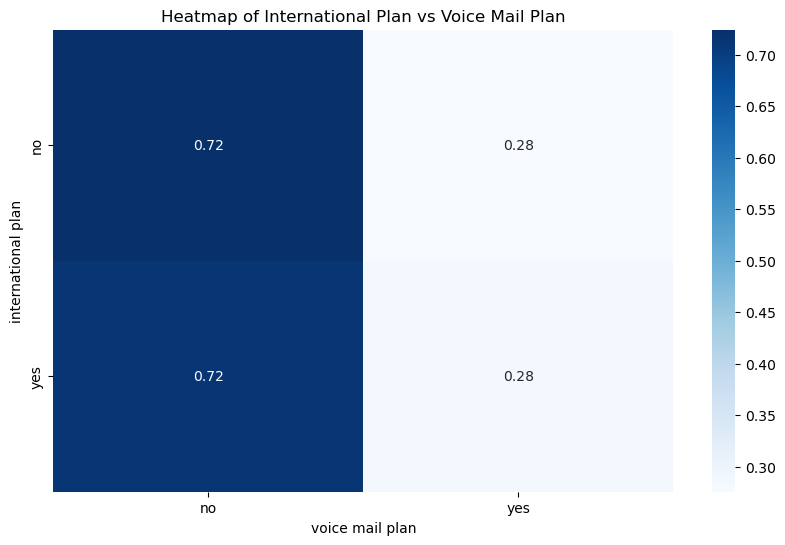

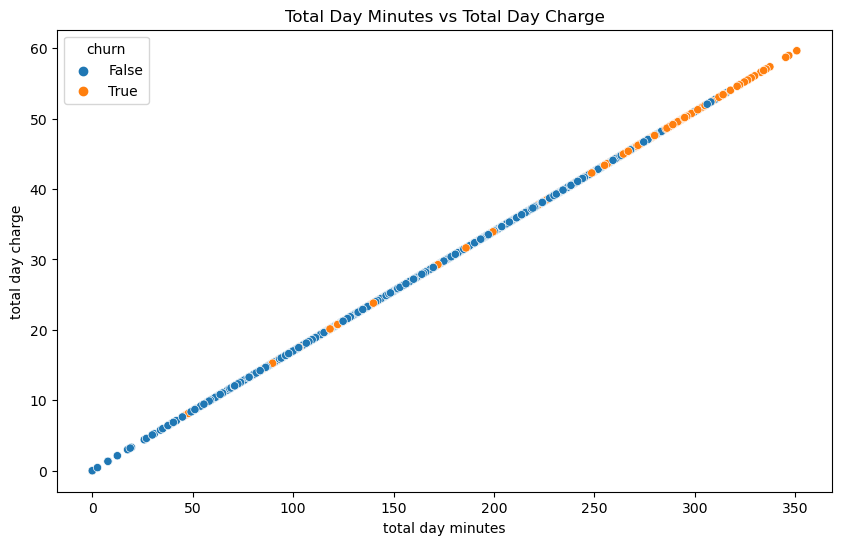

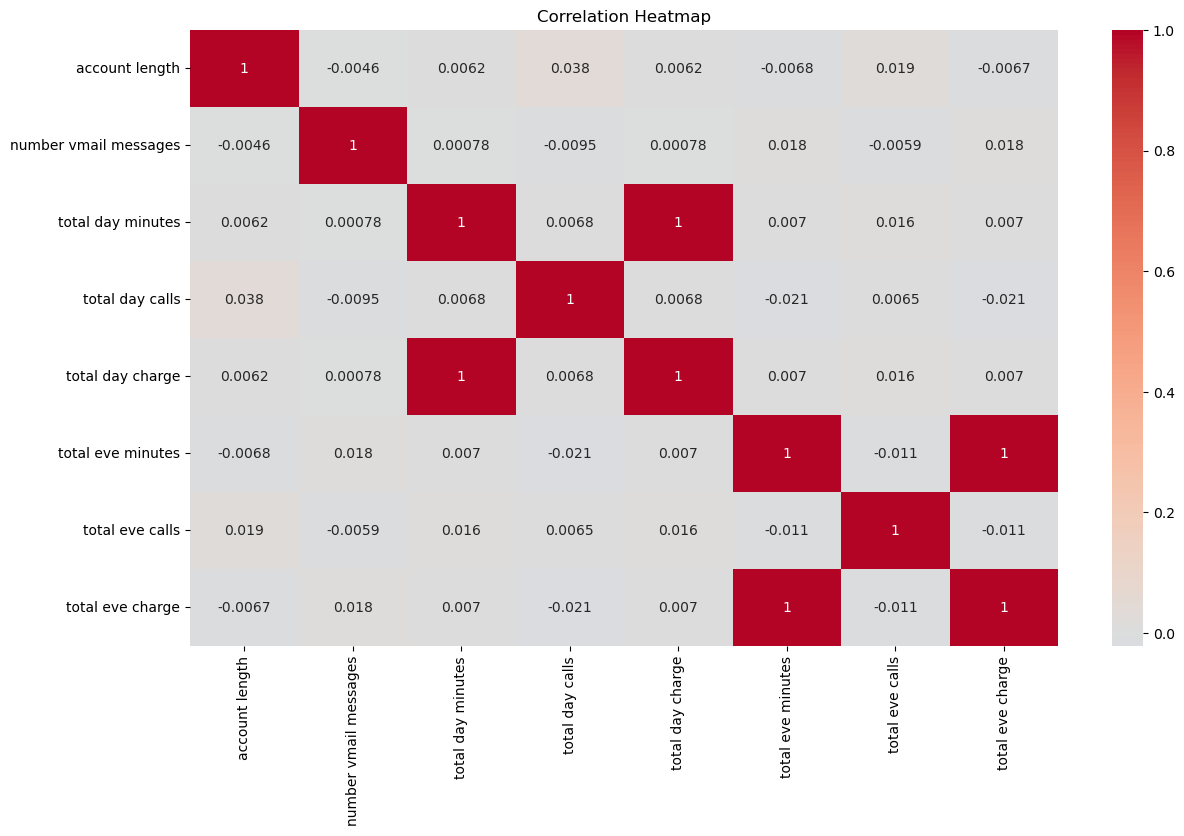

In [89]:
# Assuming DataProcessing class is already defined and imported

# Usage
file_path = 'Datasets/Customer Churn.csv'
eda = EDA(file_path)

# Load and display data
eda.load_data()

# Perform univariate analysis
eda.univariate_analysis()

# Perform bivariate analysis
eda.bivariate_analysis()


In [90]:



# List of continuous variables
continuous_vars = ['account length', 'number vmail messages', 'total day minutes', 'total day calls', 
                   'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge']

# Extracting the subset of the DataFrame with only the continuous variables
numerical_df = df[continuous_vars]

# Calculating the correlation matrix
correlation_matrix = numerical_df.corr()

# Output the correlation coefficients
print(correlation_matrix)


                       account length  number vmail messages  \
account length               1.000000              -0.004628   
number vmail messages       -0.004628               1.000000   
total day minutes            0.006216               0.000778   
total day calls              0.038470              -0.009548   
total day charge             0.006214               0.000776   
total eve minutes           -0.006757               0.017562   
total eve calls              0.019260              -0.005864   
total eve charge            -0.006745               0.017578   

                       total day minutes  total day calls  total day charge  \
account length                  0.006216         0.038470          0.006214   
number vmail messages           0.000778        -0.009548          0.000776   
total day minutes               1.000000         0.006750          1.000000   
total day calls                 0.006750         1.000000          0.006753   
total day charge            

### Key Observations from Correlation Analysis

While analyzing the Customer Churn dataset, I noticed several important relationships between the continuous features through a correlation analysis:

- **Perfect Positive Correlations**:
  - `total day minutes` and `total day charge` exhibit a perfect positive correlation (1.000000). This indicates that `total day charge` is directly derived from `total day minutes`.
  - Similarly, `total eve minutes` and `total eve charge` also show a perfect positive correlation (1.000000), suggesting that `total eve charge` is derived from `total eve minutes`.

- **Low or No Significant Correlations**:
  - There are no high negative correlations among the variables, indicating minimal inverse relationships.
  - Most other variables have very low correlation coefficients with each other, suggesting weak linear relationships.

  - Given the perfect correlations observed, I decided to remove redundant features to avoid multicollinearity in the model. Specifically, `total day charge` was removed in favor of `total day minutes`, and `total eve charge` was removed in favor of `total eve minutes`.

- **Selected Features for Modeling**:
  - To improve the model's performance and ensure distinct and non-redundant information, the following features were selected:
    - `account length`
    - `number vmail messages`
    - `total day minutes`
    - `total day calls`
    - `total eve minutes`
    - `total eve calls`

By focusing on these selected features, I aim to enhance the model's performance and interpretability, ensuring it leverages the most informative and non-redundant data.
